# Heterodyning: shifting frequencies by multiplication

This notebook gives a brief introduction to **heterodyning** (frequency translation
by multiplication) at the level of a first-year mathematics graduate student.

We will:

- Motivate heterodyning as a way to move information in the frequency domain.
- Explain the basic Fourier-analytic idea.
- Work through a concrete, numerical example using NumPy.
- Visualize what happens in both time and frequency.


## 1. Motivation

In many applications (radio communications, imaging, signal processing) we have a
time-dependent signal $x(t)$ whose **frequency content** (Fourier transform) is
concentrated near some frequency band.  

Sometimes we want to **move** that content from one frequency band to another:

- In a radio receiver, a high-frequency radio signal is multiplied by a locally
  generated oscillation so that its content is shifted down to a low ("intermediate")
  frequency where it is easier to filter and digitize.
- In imaging (e.g. Fourier optics, MRI), we often modulate signals with oscillations
  to encode spatial or temporal frequencies in a convenient band.

This operation of *shifting the spectrum* of a signal by multiplying with an
oscillation is called **heterodyning** or **mixing**.


## 2. The mathematical idea

Let $ x : \mathbb{R} \to \mathbb{C} $ be a "nice" signal with Fourier transform
$ \mathcal{F}x(f) = X(f) $.  

We use the convention
$$
X(f) = \int_{\mathbb{R}} x(t)\, e^{-2\pi i f t}\, dt.
$$

Now consider multiplying the signal by a complex exponential at frequency $f_0$:
$$
y(t) = x(t)\, e^{2\pi i f_0 t}.
$$

Then (by a one-line computation) the Fourier transform of $y$ is
$$
Y(f) = X(f - f_0).
$$

So *multiplication in time* by $e^{2\pi i f_0 t}$ corresponds to a **shift in
frequency** by $+f_0$.  

This is exactly the mechanism of heterodyning:

- If $X(f)$ is concentrated near frequencies around $f_c$,
- then $Y(f) = X(f - f_0)$ is concentrated near $f_c + f_0$.

In practice, we often use real-valued cosines instead of complex exponentials.
Using $ \cos(2\pi f_0 t) = \tfrac{1}{2}(e^{2\pi i f_0 t} + e^{-2\pi i f_0 t}) $,
multiplication by a cosine produces **two** shifted copies: one up by $+f_0$
and one down by $-f_0$.


In this notebook we will work with discrete-time signals $x[n]$ sampled at a
fixed sampling rate, and approximate their Fourier transforms using the Fast
Fourier Transform (FFT). The same intuition carries over directly.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit bigger by default
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


In [8]:
def plot_time_and_spectrum(
    t: np.ndarray,
    x: np.ndarray,
    title_time: str = "Time domain",
    title_freq: str = "Frequency domain (magnitude)",
    xlim_time: tuple[float, float] | None = None,
    freq_xlim: tuple[float, float] | None = None,
    fs: float | None = None,
) -> None:
    """Plot a real-valued signal in time and its magnitude spectrum.

    Parameters
    ----------
    t:
        Time samples, shape (N,).
    x:
        Signal samples, shape (N,), real-valued for visualization.
    title_time:
        Title for the time-domain subplot.
    title_freq:
        Title for the frequency-domain subplot.
    xlim_time:
        Optional x-axis limits for the time-domain plot.
    freq_xlim:
        Optional x-axis limits for the frequency-domain plot (in Hz).
    fs:
        Sampling rate in Hz. If provided, the frequency axis is in Hz.
        Otherwise, it is in normalized frequency units.
    """
    x = np.asarray(x)
    t = np.asarray(t)
    N = x.size

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(t, x, lw=1.5)
    ax1.set_xlabel("time")
    ax1.set_ylabel("amplitude")
    ax1.set_title(title_time)
    if xlim_time is not None:
        ax1.set_xlim(*xlim_time)

    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(N, d=1.0 / fs) if fs is not None else np.fft.fftfreq(N)
    X_shifted = np.fft.fftshift(X)
    freqs_shifted = np.fft.fftshift(freqs)

    ax2.plot(freqs_shifted, np.abs(X_shifted), lw=1.5)
    ax2.set_xlabel("frequency (Hz)" if fs is not None else "normalized frequency")
    ax2.set_ylabel("|X(f)|")
    ax2.set_title(title_freq)
    if freq_xlim is not None:
        ax2.set_xlim(*freq_xlim)

    plt.tight_layout()
    plt.show()


## 3. A simple heterodyning example

We will build a simple example that resembles amplitude modulation and
demodulation in radio:

1. Start with a low-frequency **message** signal $m(t)$ (say, 5 Hz).
2. Modulate it onto a **carrier** at a higher frequency $f_c$ (say, 50 Hz),
   forming a signal $x(t)$ whose spectrum is concentrated near $\pm f_c$.
3. Multiply (heterodyne) the received signal by a cosine at frequency $f_c$.
   This produces components around 0 Hz (baseband) and $2 f_c$.
4. Apply a low-pass filter to keep only the baseband component. This recovers
   the original message (up to a constant factor).

This is the basic idea behind many real-world receivers.


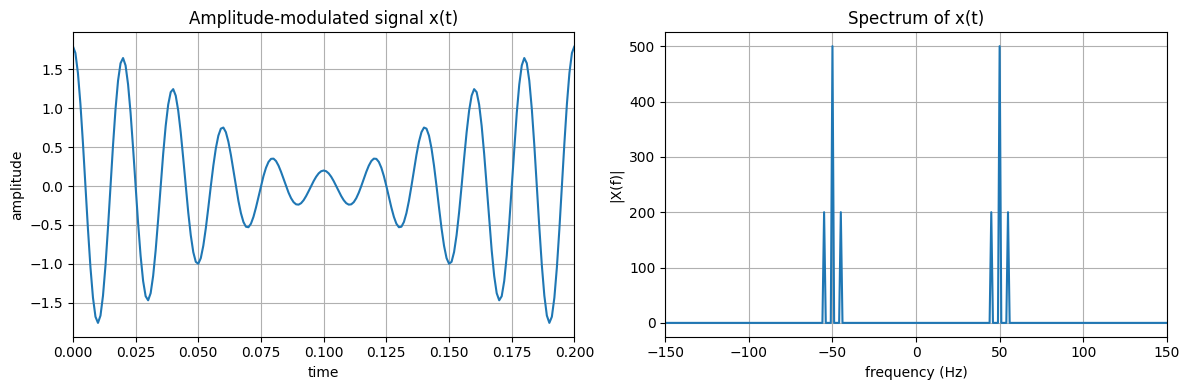

In [9]:
fs = 1000.0
T = 1.0
N = int(fs * T)
t = np.linspace(0.0, T, N, endpoint=False)

f_message = 5.0
f_carrier = 50.0

m = np.cos(2 * np.pi * f_message * t)
carrier = np.cos(2 * np.pi * f_carrier * t)
x = (1.0 + 0.8 * m) * carrier

plot_time_and_spectrum(
    t,
    x,
    title_time="Amplitude-modulated signal x(t)",
    title_freq="Spectrum of x(t)",
    xlim_time=(0, 0.2),
    freq_xlim=(-150, 150),
    fs=fs,
)


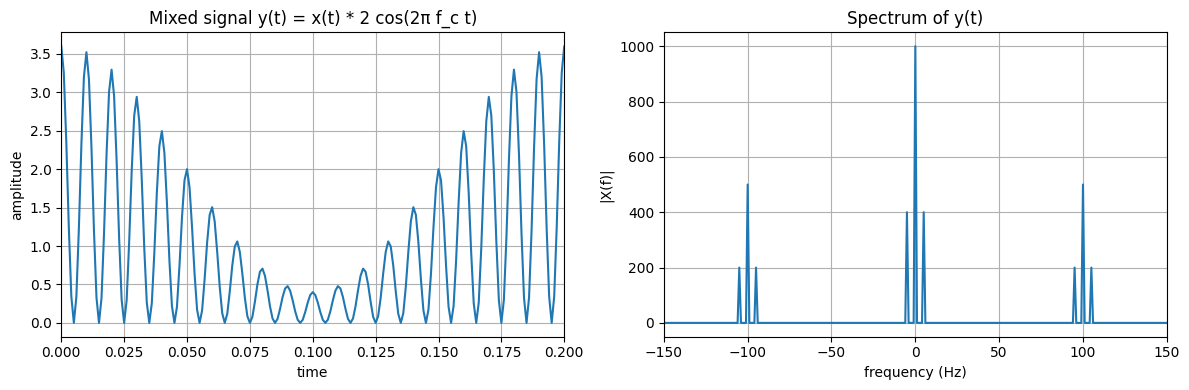

In [10]:
local_oscillator = 2.0 * np.cos(2 * np.pi * f_carrier * t)
y = x * local_oscillator

plot_time_and_spectrum(
    t,
    y,
    title_time="Mixed signal y(t) = x(t) * 2 cos(2π f_c t)",
    title_freq="Spectrum of y(t)",
    xlim_time=(0, 0.2),
    freq_xlim=(-150, 150),
    fs=fs,
)


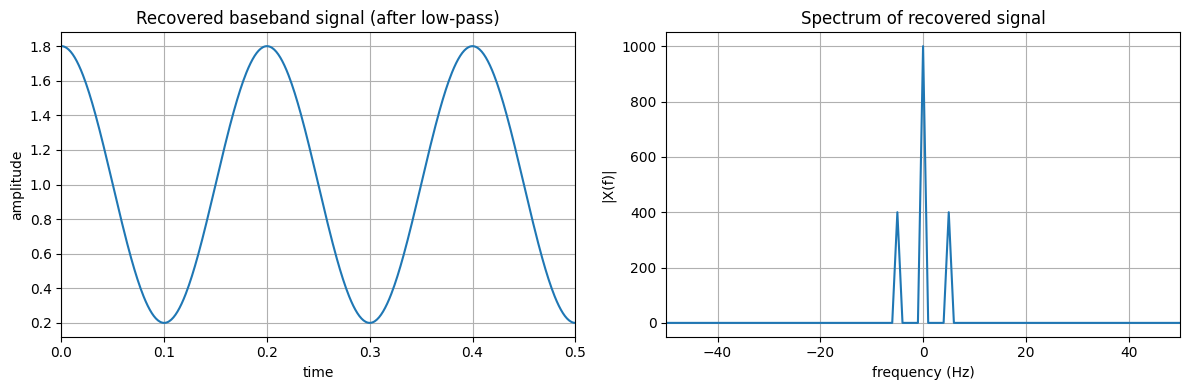

In [11]:
def ideal_lowpass_fft(x: np.ndarray, fs: float, cutoff_hz: float) -> np.ndarray:
    N = x.size
    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(N, d=1.0 / fs)
    mask = np.abs(freqs) <= cutoff_hz
    X_lp = X * mask
    x_lp = np.fft.ifft(X_lp)
    return np.real(x_lp)


cutoff = 20.0
m_rec = ideal_lowpass_fft(y, fs=fs, cutoff_hz=cutoff)

plot_time_and_spectrum(
    t,
    m_rec,
    title_time="Recovered baseband signal (after low-pass)",
    title_freq="Spectrum of recovered signal",
    xlim_time=(0, 0.5),
    freq_xlim=(-50, 50),
    fs=fs,
)


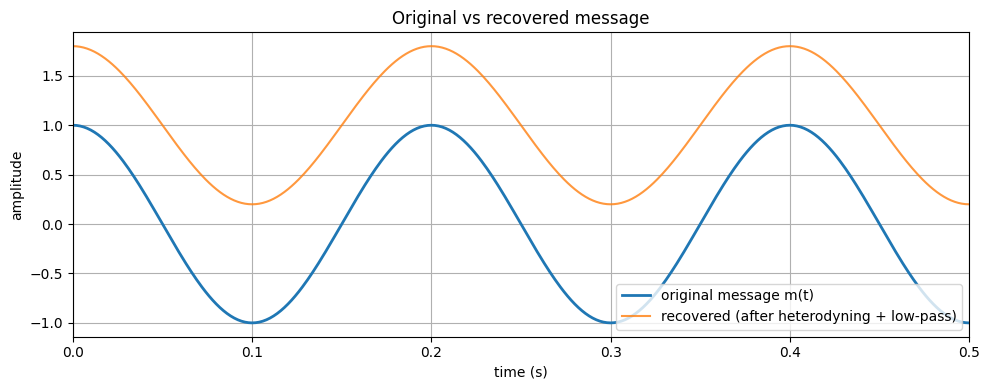

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(t, m, label="original message m(t)", lw=2)
plt.plot(t, m_rec, label="recovered (after heterodyning + low-pass)", lw=1.5, alpha=0.8)
plt.xlim(0, 0.5)
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title("Original vs recovered message")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
